In [3]:
import matplotlib as m
import matplotlib.pyplot as plt
%matplotlib qt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter, sobel
from scipy.optimize import curve_fit
from scipy import signal
from skimage import io
import os
import imageio
os.chdir(r'25.02\OneDrive_2_25-02-2022')

# Import

In [4]:
filename_post = 'Bilayer3_post bleach7_1\Bilayer3_post bleach7_1_MMStack_Default.ome.tif'
filename_pre = 'Bilayer3_pre bleach7_1\Bilayer3_pre bleach7_1_MMStack_Default.ome.tif'
im_post = io.imread(filename_post)
im_pre = io.imread(filename_pre)
print(np.shape(im_post))
print(np.shape(im_pre))

(3000, 512, 512)
(100, 512, 512)


# Find the bleached spot

In [5]:
spot = im_post[0]-im_pre[-1]
spot= gaussian_filter(spot,sigma=10)
fig, ax= plt.subplots()
plot= ax.imshow(spot,cmap=plt.cm.gray)
fig.colorbar(plot)
plt.show()

In [6]:
limit = np.mean(spot)*1.5  #set a limit of all values over 1.5 are in the spot
spot_df= pd.DataFrame(data=np.empty((512, 1)),columns={'Row'},dtype=object)
for i in range(512):
        spot_index = [idx for idx, val in enumerate(spot[i,:]) if val > limit] #Get index of values that are over the limit
        spot_df.loc[i,'Row'] = spot_index
print(spot_df)
spot_df=spot_df[spot_df['Row'].map(lambda d: len(d)) > 0] #Remove empty lists
print(spot_df)

    Row
0    []
1    []
2    []
3    []
4    []
..   ..
507  []
508  []
509  []
510  []
511  []

[512 rows x 1 columns]
                                                   Row
113  [218, 219, 220, 221, 222, 223, 224, 225, 226, ...
114  [214, 215, 216, 217, 218, 219, 220, 221, 222, ...
115  [211, 212, 213, 214, 215, 216, 217, 218, 219, ...
116  [209, 210, 211, 212, 213, 214, 215, 216, 217, ...
117  [206, 207, 208, 209, 210, 211, 212, 213, 214, ...
..                                                 ...
321  [219, 220, 221, 222, 223, 224, 225, 226, 227, ...
322  [221, 222, 223, 224, 225, 226, 227, 228, 229, ...
323  [223, 224, 225, 226, 227, 228, 229, 230, 231, ...
324  [226, 227, 228, 229, 230, 231, 232, 233, 234, ...
325  [231, 232, 233, 234, 235, 236, 237, 238, 239, ...

[213 rows x 1 columns]


# Find the average value in the selected area

In [18]:

average_intensity=np.empty((1000,1))
wholeimage_intensity=np.empty((1000,1))

for k in range(1000):
    int_array=np.empty((0,1))
    row_array=np.empty((0,1))
    column_array=np.empty((0,1))
    
    #intensity_df = pd.DataFrame(columns={'Row', 'Column', 'Intensity'})
    wholeimage_intensity[k]=np.sum(im_post[k,:,:]) #find the sum of the intensity of the whole image
    
    
    
    for i in range(len(spot_df['Row'])):    #Iterate over all the rows in the df
        for j in range(len(spot_df.iloc[i,0])):    #Iterate over all the elements in each row
            
            
            int_array= np.vstack((int_array,im_post[k,spot_df.index[i],spot_df.iloc[i,0][j]]))
            
            row_array= np.vstack((row_array,spot_df.index[i]))

            column_array= np.vstack((column_array,spot_df.iloc[i,0][j]))

            
            #print(im_post[0,spot_df.index[i],spot_df.iloc[i,0][j]])
            #print(spot_df.index[i])
            #print(spot_df.iloc[i,0])
            #im_post[0,spot_df.index[i],spot_df.iloc[i,0][j]]=100000000 #So can graph spot area



    #intensity_df = pd.DataFrame({'Row':row_array.tolist(), 'Column':column_array.tolist(), 'Intensity':int_array.tolist()})
    average_intensity[k]=np.mean(int_array)  #find the mean in the spot
    sum_spot_intensity=np.sum(int_array) #Add all the intensities in the spot
    
    print(k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Find the Photo-fading calculation

In [25]:
photofading= wholeimage_intensity-sum_spot_intensity
x= np.array([i for i in range(1000)])
fig,ax= plt.subplots()
ax.plot(x,photofading)


plt.show()

# Save whole image to a text file

In [23]:
whole_image = open("whole_image.txt", "w")
for row in wholeimage_intensity:
    np.savetxt(whole_image, row)
whole_image.close()

# Save recovery to a text file

In [ ]:
recovery_file = open("recovery.txt", "w")
for row in average_intensity:
    np.savetxt(recovery_file, row)
recovery_file.close()

# Fit model to recovery

In [66]:
x= np.array([i for i in range(1000)])
def func(x,a,b,c):
    return a*(1-np.exp(-x/b))+c

popt, pcov = curve_fit(func, x, average_intensity[:,0], maxfev=10000000, p0=[4300,2600,1000])#, method='lm')#
print(popt)
print(pcov)
perr_sd = np.sqrt(np.diag(pcov))
print(perr_sd)

[704.77830221 416.52560193 991.6584588 ]
[[ 1.58360963  1.48884736 -0.25749675]
 [ 1.48884736  5.52805472  1.76978154]
 [-0.25749675  1.76978154  1.09711142]]
[1.25841552 2.35118156 1.04743087]


# Plot Recovery

In [80]:
fig,ax= plt.subplots()
ax.plot(x,average_intensity)
a, b, c = popt
ax.plot(func(x, *popt),alpha =0.5,linestyle='dashdot',color='red', label= 'Model')
ax.legend(loc="center right", frameon=False)
ax.text(np.max(x)/10,np.max(average_intensity)*0.95, r'$('+str(round(a))+u'\u00B1'+str(round(perr_sd[0]))+ r'$' + r'$)(1-exp$'+r'$[\frac{-x}{(' + str(round(b,4))+u'\u00B1 '+str(round(perr_sd[1],4))+ ')}])$' + r'$ +(' +str(round(c)) +u' \u00B1' + str(round(perr_sd[2])) +')}$', color='black')
fig.set_size_inches(18.5, 10.5)
plt.savefig('recovery.png', dpi=1000)

# Plot first image of post and last of pre

In [23]:
fig, ax= plt.subplots()
plot= ax.imshow(im_post[0],cmap=plt.cm.gray)
fig.colorbar(plot)
plt.show()

In [26]:
fig, ax= plt.subplots()
plot= ax.imshow(im_pre[-1],cmap=plt.cm.gray)
fig.colorbar(plot)
plt.show()

# Make gif

MovieWriter ffmpeg unavailable; using Pillow instead.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



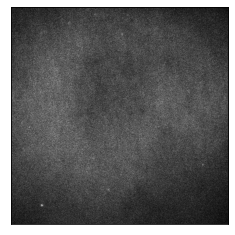

In [10]:
fig,ax= plt.subplots()
gif_ims = []
for i in range(np.shape(im)[0]-2000):
        gif_im= ax.imshow(im[i,:,:],cmap=plt.cm.gray)
        ax.xaxis.set_visible(False)# Turn off tick labels
        ax.yaxis.set_visible(False)
        gif_ims.append([gif_im])
ani = animation.ArtistAnimation(fig, gif_ims, interval=200, repeat_delay=0,blit=True)
ani.save(filename[:-4]+'.gif',dpi=300)